#Consigna

Dada la siguiente imagen de entrada, aplicar todos los conocimientos adquiridos en el módulo de segmentación para extraer la única célula que se destaca del resto.

a)

1.     ¿Qué métodos de segmentación se podrían utilizar en este caso? ¿Cuál conceptualmente le parece el más adecuado? Justificar y probar
2.  ¿Se puede realizar una segmentación por color? Justificar y probar. Pensar en separar la imagen en las tres capas de color (RGB).
3. ¿Se puede realizar una segmentación por texturas? ¿Qué métricas de textura
servirían para diferenciar esa célula particular del resto de células que se encuentran en la imagen? Justificar y probar. Alguna capa de color podría ayudar más que otra en este caso?
4.  Calcular el índice de Dice y Jaccard según su segmentación resultante y la
segmentación que se encuentra en la imagen img21.jpg


#Montado del Drive e instalación de librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##Instalar e importar librerías
!pip install SimpleITK

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import scipy


     |████████████████████████████████| 48.4 MB 5.2 kB/s 


#Funciones a utilizar

##Otsu

Este método de umbralizado permite separar frente y fondo mediante un umbral. El algoritmo asume que la imagen, en escala de grises, posee dos clases de pixels (frente y fondo). Calcula el umbral óptimo de separación de dichas clases tal que se minimice la varianza intra-clase, es decir se maximice la varianza inter-clase. L son los niveles de gris, t es igual al umbral de OTSU más 1 (k+1), i la intensidad del pixel. En la práctica hacemos todos los cálculos con distintos umbrales (desde la intensidad mínima a la máxima) y vamos comparando la varianza interclase. Aquel umbral que la haga máxima es el umbral elegido por el algoritmo para binarizar la imagen.

In [ ]:
def Otsu(imagen):
  #Paso 1: Calculamos el histograma normalizado (dividido por la cantidad de píxeles)
  p= Histograma(imagen)/np.size(imagen) #Agarro todos mis neveles de grises.

  #Paso 2: Definimos un vector (np.zeros) de varianza inter-clase (dimensión 256)
  L = 256 #por ser uint8
  Varianza = np.zeros(L)
  # Puedo armarme un vector de todos ceros que tenga longitud 256, arranco el ciclo para iterar , calculo la varianza para cada valor de t y
  #la voy guardando en ese vector que previamente defini con todos ceros. Entonces consigo un vector donde cada elemento del vector me va a decir la varianza interclase para ese nivel de gris.
  #Veo cual es el valor maximo, veo cual es la posicion dentro del vector. Esa posicion me va a decir cual es el umbral de otsu, el umbral optimo con el que voy a binarizar mi imagen.

    # Calculo el valor de muT
  #muT= valor promedio total que tengo en la imagen, valor medio de cada calse




  #Paso 3: Armo fórmulas para calcular la varianza 256 veces, con t=1...256
  #Arranco con T=1 hasta T=256 y armo el algoritmo de manera tal que haga 256 iteraciones y calculo la varianza interclase para cada valor de t.

   # Calculo los valores de w0 y w1
  #w1= probabilidad de encontrar pixeles mayores a 100 en mi imagen original ( t=100)
  #w0=  probabilidad de encontrar pixeles menores a 100 en mi imagen original ( t=100). w0 +w1=1

  #Aplico formulas del algoritmo
  for t in range(1,L):
    w0 = mu0 = mu1 = varianza = 0

    for i in range(t):
      w0 = w0 + p[0,i]
      mu0 = mu0 + i * p[0,i]

    for i in range(t,L):
      mu1 = mu1 + i * p[0,i]

    w1 = 1 - w0
    mu0 = mu0/w0
    mu1 = mu1/w1

    Varianza[t-1] = w1 * w0 * (mu0 - mu1) ** 2

  #Paso 4: Me quedo con el nivel de gris que maximiza la varianza (busco el máximo del vector de varianzas y me fijo la posición en la que está el máximo, ese va a ser el t óptimo)

  t_optimo = np.argmax(Varianza)

  #Paso 5: Binarizamos la imagen con el umbral t óptimo

  M = imagen.shape[0]
  N = imagen.shape[1]
  imagen_resultante = np.zeros(imagen.shape)

  for i in range(M):
    for j in range(N):
      if imagen[i,j] > t_optimo:
        imagen_resultante[i,j] = 255 #si es mayor que el umbral entonces 255

  return imagen_resultante,t_optimo

In [ ]:
def Histograma(Imagen):
  M = Imagen.shape[0]
  N = Imagen.shape[1]
  Histograma = np.zeros((1,256))

  for i in range(M):
    for j in range(N):
      tono = Imagen[i,j]
      Histograma[0,tono] += 1

  return Histograma

##Region Growing

Region Growing busca, a partir de una semilla que se le pasa como parámetro inicial, una región conexa. Básicamente, evalúa los puntos vecinos de la semilla y si la intensidad en los mismos se encuentra dentro de un umbral determinado, se consideran parte de la región conexa.  Una vez que se obtienen los vecinos pertenecientes, se analizan los vecinos de esos puntos y así sucesivamente hasta llegar a completar la región conexa.

El objetivo aca tambien es obtener una imagen binaria.

Si me paro en mi pixel semilla 300x300, ese punto va a ser blanco. Hasta ahi, tengo una imagen negra, con un pixel blanco que es la coordenada. Ahora tengo que agarrar los vecinos de ese pixel. Me paro en el primer vecino y pregunto: ese pixel cumple la condicion de asignación. Si la cumple en la coordenada de ese pixel voy a poner un blanco, sino lo dejo en negro como estaba .

Supongamos que mi pixel semimlla tiene nivel de gris=100.  Para construir mi regla de asignacion, defino un valor, por ejemplo 20, y yo quiero que la regla de asignacion sea: que el vecino de mi pixel semilla, este en un rango de 100+-20 ( de 80 a 120). Si mi pixel vecino tiene un nivel de gris en ese rango, lo pongo blanco, sino negro, y asi con todos. De esa  manera voy haciendo crecer una region blanca que crece a partir de mi pixel semilla en todas las direcciones. La voy a ir haciendo crecer para todos lados. Crece hasta que no haya ningun pixel conectado a esa region que cumpla la regla de asignacion. El algoritmo me termina devolviendo una imagen negra, donde la region que me aparece en blanco es resultado de crecimiento de region.

Nota: Cuando plantamos una semilla y analizamos los vecinos, los que cumplieron la regla de asignacion, pasan a ser punto semilla. Arranco mi algoritmo con una semilla, pero despues se van sumando semillas


Tips:

Tomamos la coordenada del punto semilla y vemos que nivel de gris tiene. Tomamos los píxeles vecinos a ese pixel, ya sea 4 u 8 vecinos. Tenemos que hacer varias preguntas.
* La coordenada del punto semilla es una coordenada de borde? Tener en cuenta que no vamos a poder tomar todos sus vecinos.
* Preguntamos si el píxel semilla ya se evaluó (en el caso de tener muchos puntos semillas).
* Tomamos los vecinos de ese punto, nos paramos en el primer vecino, preguntamos si ese punto se evaluó, si no, siendo i la intensidad de nivel de gris del punto semilla, i-q a i+q es la regla de pertenencia para añadir los píxeles a la región, entonces nos fijamos si la intensidad de nivel de gris de ese vecino se encuentra dentro del rango i-q a i+q, si es asi lo ponemos en 1 o 255 (en una nueva matriz- matriz final- imagen binaria)
* Luego tomamos el segundo, tercer.. vecino y hacemos lo mismo. Después vamos a tomar los vecinos de los vecinos, y vamos a hacer crecer la región de esa manera hasta que ningún vecino cumpla la regla de pertenencia.
* Si tenemos mas de un punto semilla comenzamos de nuevo desde ese otro punto.   

In [ ]:
def Region_growing(Semilla_inicial, umbral_min , umbral_max,imagen):

  i=Semilla_inicial[0]
  j=Semilla_inicial[1]

  if umbral_max > imagen[i,j] > umbral_min: #Propago sólamente si la semilla inicial cumple con el rango de umbrales.

    Lista_semillas = []
    Lista_semillas.append(Semilla_inicial)

    Imagen_Resultante= np.zeros(imagen.shape)
    Imagen_rastreo = np.zeros(imagen.shape)  # La imágen de rastreo se usa para registrar los puntos por los que ya pasé y sea más fácil de rastrearlos.

    # Registro la semilla inicial.
    Imagen_Resultante[i,j] = 1
    Imagen_rastreo[i,j] = 1

    # Obtengo las dimensiones de la imágen.
    M = imagen.shape[0]
    N = imagen.shape[1]

    while Lista_semillas != []:

      Semilla=Lista_semillas.pop() #Extraigo la primer semilla dentro de Lista_semillas y a su vez la quito. Como si fuese un dispenser de semillas.
      i=Semilla[0]
      j=Semilla[1]

      # Una solución al problema de los bordes
      imin = i-1; imax = i+2; jmin = j-1; jmax = j+2 # Estos son los límites de la vecindad de 8 de mi semilla(límite máx excluyente).
      # A medida que me voy encontrando con los bordes voy modificando estos límites para no tener problemas con las dimensiones.
      if i == 0:
        imin = i
      elif i == M-1:
        imax = i+1
      if j == 0:
        jmin = j
      elif j == N-1:
        jmax = j+1

      for m in range(imin,imax): # Recorro la vecindad de la semilla con los límites correspondientes.
        for n in range(jmin,jmax):

          if (m,n) != (i,j): # El centro ya es la semilla.

            if Imagen_rastreo[m,n] != 1:  #Verifico que no haya pasado por este punto previamente.

              if umbral_max >= imagen[m,n] >= umbral_min: # Si está dentro del rango lo pinto de blanco en la imágen resultante y lo agrego como nueva semilla en Lista_semillas (refill del dispenser).
                Lista_semillas.append((m,n))
                Imagen_Resultante[m,n] = 1

            Imagen_rastreo[m,n] = 1  # indico con un 1 que ya pasé por este punto en la imágen de rastreo.



    return Imagen_Resultante

  else:
    print("La semilla inicial no cumple con la regla de asignación fijada.")

##K means


Este algoritmo me va a separar la imagen de entrada de niveles de grises, en 3 partes diferentes si realizamos un kmeans con 3 centroides, es decir, voy a obtener 3 clusters de la imagen original.

Vamos a inicializar el algoritmo con  centroides (3 valores de niveles de grises), vamos a recorrer toda la imagen pixel a pixel y vamos a calcular la distancia de cada pixel (según su intensidad) a cada centroide, luego asignamos ese pixel al cluster con el que menor distancia tenga.

In [ ]:
def kmeans(imagen,c1,c2,c3):
  #Paso 1: Defino centroides iniciales (c1,c2,c3)
  A = len(imagen)
  B = len(imagen[0])

  media1 = 0
  media2 = 0
  media3 = 0
  #Paso 2: Recorremos píxel a píxel la imagen y calculamos la distancia de cada píxel (nivel de gris) al centroide
  #Nivel de gris del píxel es n
  i = 0

  while (media1 != c1) and (media2 != c2) and (media3 != c3):
    imagenNuevac1 = np.zeros([A,B])
    imagenNuevac2 = np.zeros([A,B])
    imagenNuevac3 = np.zeros([A,B])

    lista1=[]
    lista2=[]
    lista3=[]

    if (i != 0):
      c1 = media1
      c2 = media2
      c3 = media3

    for i in range(A):
      for j in range(B):
        #calculo la distancia de ese pixel a cada centroide
        distancia1 = abs(c1-imagen[i,j])
        distancia2 = abs(c2-imagen[i,j])
        distancia3 = abs(c3-imagen[i,j])
        listaDistancias = [distancia1, distancia2, distancia3]
        #Cuál es la mínima distancia?
        minimo = np.min(listaDistancias)

        if (minimo == distancia1):
          lista1.append(imagen[i,j])
          imagenNuevac1[i,j] = 255
        elif (minimo == distancia2):
          lista2.append(imagen[i,j])
          imagenNuevac2[i,j] = 255
        else:
          lista3.append(imagen[i,j])
          imagenNuevac3[i,j] = 255
    #Paso 3: Una vez que ya recorrí toda la imagen tengo que agarrar los píxeles que forman parte de cada uno de los clusters y hacer un promedio que va a resultar en el valor del nuevo centroide del clúster 1
    #Debo transformar c1, c2 y c3 a números enteros
    media1 = int(np.sum(lista1)/len(lista1))
    media2 = int(np.sum(lista2)/len(lista2))
    media3 = int(np.sum(lista3)/len(lista3))
   #Paso 4: Una vez recalculados los centroides, repetir el proceso (desde Paso 2), hasta que el valor de los centroides no cambie más o tengan una diferencia muy chica (definir un error permitido)
    i = i+1

  return (imagenNuevac1,imagenNuevac2,imagenNuevac3,c1,c2,c3)


##Indices de calidad para segmentacion

Los índices de Jaccard y dice son métricas que se utilizan para evaluar la calidad de la segmentación, y están dados por las siguientes fórmulas:

J(A,B) = |A ∩ B| / |A ∪ B| ; donde |A ∪ B|  = |A|  + |B| - |A ∩ B|

D(A,B) =  2*|A ∩ B| / ( |A|  + |B|)

A mayor valor de estos indices, que toman valores entre 0 y 1, mayor calidad de segmentación.

In [ ]:
def jaccard(img1,img2):
  img3=img1+img2
  interaccion = (img3 == 2).sum() #cantidad de veces que A y B coinciden en blanco
  union = (img3 == 1).sum() + interaccion #cantidad de veces que A y b  son 1
  jaccard = interaccion/union

  return jaccard

In [ ]:
def dice(img1,img2):
  img3=img1+img2
  interaccion = (img3 == 2).sum() #cantidad de veces que A y B coinciden en blanco
  unos_1 = (img1 == 1).sum() #cantidad de veces que A es 1
  unos_2 = (img2 == 1).sum() #cantidad de veces que B es 1
  dice = 2*interaccion/(unos_1 + unos_2)

  return dice

##Operaciones basicas de segmentacion

* Dilatación: Hace crecer una región en la imagen (región blanca o frente)
* Erosión: Reduce una región o lo que es lo mismo hace crecer el fondo de la imagen.
* Apertura: Primero erosión y luego dilatación (abrir huecos o eliminar píxeles aislados)
* Cierre: Primero dilatación y luego erosión (cerrar huecos)

In [ ]:
# Algoritmo para la Dilatacion de una Imagen

def dilatacion(imagen):
  resultante = binary_dilation(imagen)
  return resultante

# Algoritmo para la Erosion de una Imagen

def erosion(imagen):
  resultante = binary_erosion(imagen)
  return resultante

# Algoritmo para la Apertura de una Imagen

def apertura(imagen):
  resultante = binary_opening(imagen)
  return resultante

# Algoritmo para el Cierre de una Imagen

def cierre(imagen):
  resultante = binary_closing(imagen)
  return resultante

##Matriz de Coocurrencia

La matriz de co-ocurrencia nos informa la probabilidad de ocurrencia de una cierta combinación de intensidades de niveles de gris para un sentido  especificada entre un pixel de referencia y su vecino en dicho sentido.

Indica cuantas veces ocurre cada una de todas las combinaciones de niveles de grises posibles (dadas por las entradas de sus filas y columnas entre dos pixeles en un sentido específico).  Las matrices de co-ocurrencias son como mínimo cuatro para hacer el análisis de texturas

In [ ]:
def Coocurrencia(img,dir):
  filas = img.shape[0]
  cols = img.shape[1]

  aux = np.ones((filas,cols))
  array = np.multiply(aux,img)

  max = int(np.max(array))
  min = int(np.min(array))

  if max-min == 0:
    matriz = np.ones((1,1))
  else:
    #creo la matriz teniendo en cuenta los valores mínimo y máximo de gris de la imagen
    matriz = np.zeros((max-min+1,max-min+1))

    if dir==0:
      #Dirección horizontal
      for i in range(filas):
        for j in range(cols-1):
          a = img[i,j]
          b = img[i,j+1]
          indice_a = int(a-min)
          indice_b = int(b-min)
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==45:
      #Dirección diagonal para abajo
      for i in range(1,filas):
        for j in range(cols-1):
          a = img[i,j]
          b = img[i-1,j+1]
          indice_a = int(a-min)
          indice_b = int(b-min)
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==90:
      #Dirección vertical
      for i in range(filas-1):
        for j in range(cols):
          a = img[i,j]
          b = img[i+1,j]
          indice_a =int(a-min)
          indice_b = int(b-min)
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==135:
      #Dirección diagonal para abajo
      for i in range(filas-1):
        for j in range(cols-1):
          a = img[i,j]
          b = img[i+1,j+1]
          indice_a = int(a-min)
          indice_b = int(b-min)
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces


    #Normalizo la matriz
    factor =  2*((max-min+1)**2)
    matriz = matriz/factor
  return matriz

In [ ]:
def cooncurrencia_completa(img):
  m_H=Coocurrencia(img,0)
  m_V=Coocurrencia(img,90)
  m_d1=Coocurrencia(img,45)
  m_d2=Coocurrencia(img,135)
  matriz=m_H+m_V+m_d1+m_d2

  return matriz

##Metricas textura

In [ ]:
def energia(matriz):
  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      potencia=matriz[i,j]**2
      suma=suma+potencia
  return suma

def entropia(matriz):
  import math
  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      if matriz[i,j]!=0:
        operacion=matriz[i,j]*math.log(matriz[i,j],2)
        suma=suma+operacion
      else:
        operacion=0
        suma=suma+operacion
  return suma

def contraste(matriz):
  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=((i-j)**2)*matriz[i,j]
      suma=suma+operacion
  return suma

def correlacion(matriz):
  import math
  media=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=i*matriz[i,j]
      media=media+operacion

  sigma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=((i-media)**2)*matriz[i,j]
      sigma=sigma+operacion

  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=((i-media)*(j-media)*matriz[i,j])/sigma**2
      suma=suma+operacion
  return suma


def IDM(matriz):
  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=(1/(1+(i-j)**2))*matriz[i,j]
      suma=suma+operacion
  return suma

def cluster_shade(matriz):
  media=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=i*matriz[i,j]
      media=media+operacion
  suma=0
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
      operacion=(((i-media)+(j-media))**3)*matriz[i,j]
      suma=suma+operacion

  return suma

def metricas(matriz):
  import pandas as pd
  df = pd.DataFrame()
  df['Energia'] = [energia(matriz)]
  df['Entropia'] = [entropia(matriz)]
  df['Contraste'] = [contraste(matriz)]
  df['Correlacion'] = [correlacion(matriz)]
  df['IDM'] = [IDM(matriz)]
  df['cluster_shade'] = [cluster_shade(matriz)]
  return df

#Resolucion del ejercicio

Primero cargo la imagen:

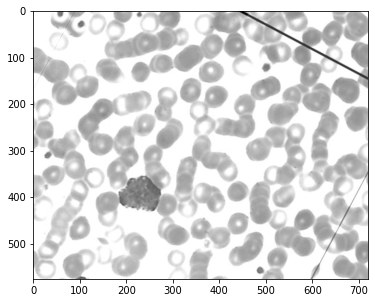

In [ ]:
imagen = cv2.imread('/content/drive/MyDrive/PIB/Segmentacion/img20.jpg',0)

plt.figure(figsize=(6,6))
plt.imshow(imagen, cmap="gray")
plt.show()

#Inciso A

**¿Qué métodos de segmentación se podrían utilizar en este caso? ¿Cuál conceptualmente le parece el más adecuado? Justificar y probar**


Considerando los metodos de segmentacion que vimos, analizo qué algoritmo podria funcionar  cual no:



*   OTSU: Este método de umbralizado permite separar frente y fondo mediante un umbral. El algoritmo asume que la imagen, en escala de grises, posee dos clases de pixels (frente y fondo). Por esta razon, creo que NO seria adecuado utilizarlo, en esta imagen tenemos el fondo, celulas y ademas una celula de interes, por lo tanto con OTSU no será posible segmentar estos tres grupos.
*  Watershed: Es un algoritmo de morfología matemática que hace operaciones para cambiar las formas de segmentación.
La segmentación a partir del algoritmo de watershed es una técnica morfológica de segmentación de imágenes de niveles de gris a partir de la topología subyacente entre las intensidades. Es un método de segmentación basado en regiones, que divide todo el dominio de la imagen en conjuntos conexos. La razon por la que creo que no funcionaría en este caso, es que en este algoritmo si le doy una imagen que no esta muy limpia y pensada para que luego se use watershed, voy a tener una sobresegmentacion, una sobredeteccion de sectores. Por lo tanto en este caso creo que habria sobresegmentacion en caso de aplicarlo: generaría segmentacion cuando no deberia haber.

*   K-means: es capaz de separar la imagen en tres niveles de grises. Por lo tanto considero que este metodo podria ser util ya que vemos 3 niveles de grises marcados en la imagen: el fondo, la celula principal y las otras celulas mas pequeñas de otro color.

* Region growing: este algoritmo como ya explique, consiste en definir un punto en la imagen como punto semilla y el objetivo es hacer crecer la región alrededor de la semilla que yo plante. Ese crecimiento se va a dar siempre y cuando los pixeles de alrededor cumplan alguna condición. Tengo que definir una asignación, un rango de niveles de grises en los que se pueden en contrar mi semilla. Si en este caso coloco mi semilla en la celula de interes, creo que se podria obtener un muy buen resultado

* Esqueletizacion:  La esqueletización es una técnica que reduce una imagen a un conjunto de líneas y curvas conectadas, de un píxel de grosor, las cuales mantienen la geometría y topología de la imagen original.  Este algoritmo no otorga un resultado similar al que se pide, al contrario, se queda unicamente con el esqueleto de la imagen.

* Contorno activo: no seria de utilidad porque no queremos solo el contorno


Ademas, considero que seguramente sea necesario aplicar algoritmos de dilatacion y erosion para mejorar el resultado.




Lo primero que hago es correr el algoritmo de otsu para analizar si lo que estableci es correcto o no:

###Otsu

Vemos que OTSU solo puede separar en dos clases, por lo tanto no logra distinguir a la celula de interes del resto, esto era de esperarse porque en general otsu se utiliza para separar el frente del fondo

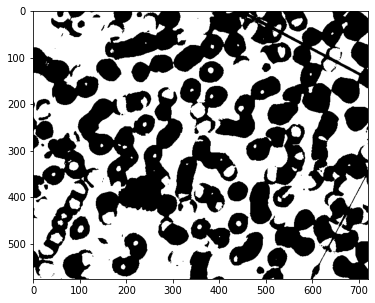

In [ ]:
im_otsu=Otsu(imagen)
plt.figure(figsize=(6,6))
plt.imshow(im_otsu[0],cmap='gray')
plt.show()

213.0


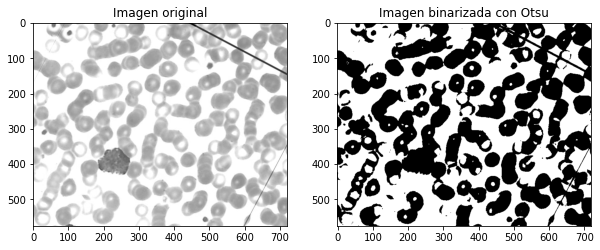

In [ ]:
umbral, Img_Otsu = cv2.threshold(imagen,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(umbral)
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(imagen,cmap='gray'),plt.title('Imagen original')
plt.subplot(122),plt.imshow(Img_Otsu,cmap='gray'),plt.title('Imagen binarizada con Otsu')
plt.show()

### Region Growing

Procedo a implementar el algoritmo de Region Growing, para eso realizo el histograma y analizo qué valores son correctos como umbrales para plantar mi semilla.

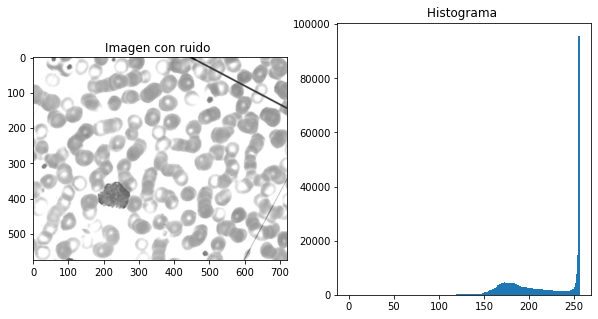

In [ ]:
hist=histograma(imagen,np.max(imagen)+1)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(imagen, cmap="gray", vmin=0, vmax=255), plt.title('Imagen con ruido ')
plt.subplot(122),plt.bar(np.arange(256), hist, width=1.2, align='edge'),plt.title('Histograma ')
plt.show()

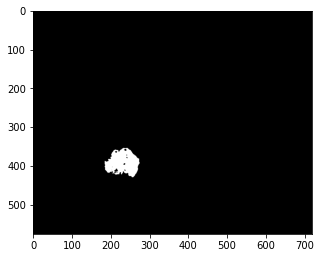

In [ ]:
im_rg=Region_growing((400,250),50,150,imagen)
plt.figure(figsize=(5,5))
plt.imshow(im_rg, 'gray')
plt.show()

Vemos que el resultado obtenido muy bueno. Sin embargo, quedan algunos pixeles negros dentro de la celula de interes. Por lo tanto procedo a dilatar la imagen, justamente para "rellenar" los pixeles. Dilatar la imagen binaria es hacer crecer una region en la imagen, es aumentar el frente.


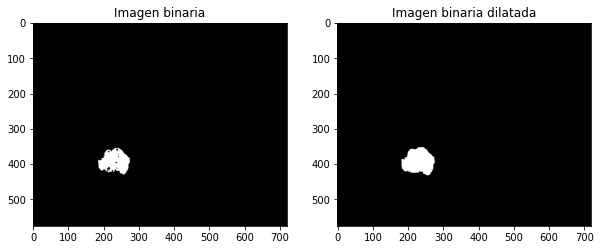

In [ ]:
kernel = np.ones((5, 5), 'uint8')

dilate_img_rg = cv2.dilate(im_rg, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(im_rg,cmap='gray'),plt.title('Imagen binaria')
plt.subplot(122),plt.imshow(dilate_img_rg,cmap='gray'), plt.title('Imagen binaria dilatada')
plt.show()

### Kmeans

Intento con K means, que por lo que explique anteriormente, podria funcionar

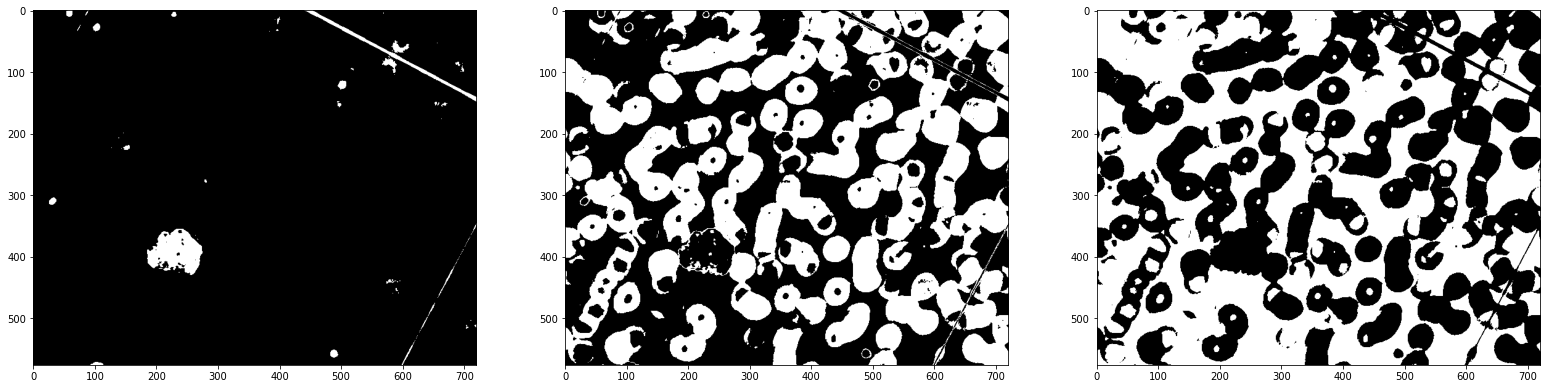

In [ ]:
celula,imagenC2,total,C1,C2,C3 = kmeans(imagen,20,90,150)

f1, axs1 = plt.subplots(1,3,figsize=(27,27))
plt.subplot(131)
plt.imshow(celula,cmap = 'gray')
plt.subplot(132)
plt.imshow(imagenC2,cmap = 'gray')
plt.subplot(133)
plt.imshow(total,cmap = 'gray')

Vemos que se pueden distinguir tres niveles de grises. El centroide 1 es el que nos interesa y por lo tanto, procedo a erosionar la imagen para eliminar los puntos blancos que no son de interes.  Al hacer la erosion, se reduce el frente, disminuye el tamaño al objeto y hacemos crecer el fondo. Lo malo de erosion es que le cambie el tamaño.

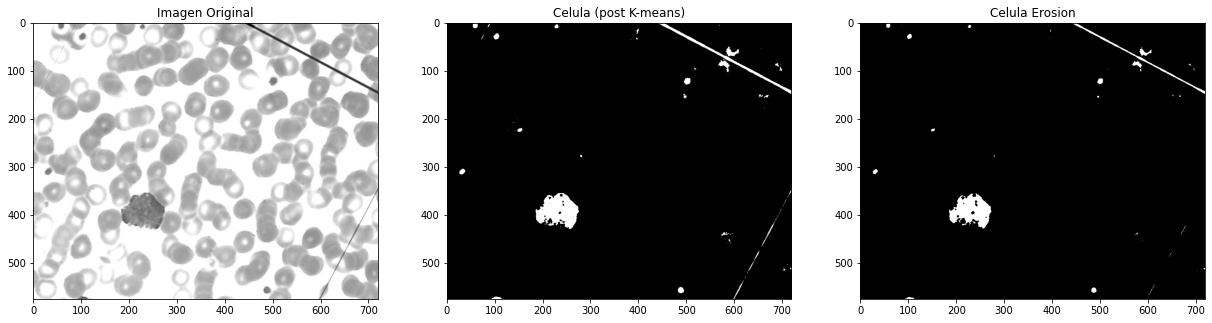

In [ ]:
celula_erosion = erosion(celula)
f3, axs3 = plt.subplots(1,3,figsize=(21,21))
plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(imagen,cmap='gray')

plt.subplot(132)
plt.title('Celula (post K-means)')
plt.imshow(celula,cmap = 'gray')

plt.subplot(133)
plt.title('Celula Erosion')
plt.imshow(celula_erosion,cmap = 'gray')

Como no es suficiente con la erosion, lo que decido hacer es recortar  la parte de la imagen que es de interes:

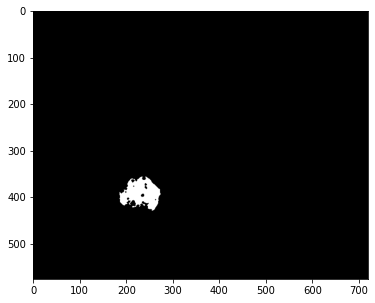

(576, 720)

In [ ]:
A =len(imagen)
B = len(imagen_objetivo[1])

imagen_final = np.zeros([A,B])

#Me quedo solo con la parte de interes de la imagen elegida
imagen_final[300:500,100:300] = celula_erosion[300:500,100:300]

plt.figure(figsize=(6,6))
plt.imshow(imagen_final, cmap="gray")
plt.show()

imagen_final.shape


Ahora, lo que hago es realizar una dilatacion de la imagen para recuperar la forma y obtener un resultado mas cercano al pedido en la consigna, que es analogo a lo que realice luego de realizar Region Growing

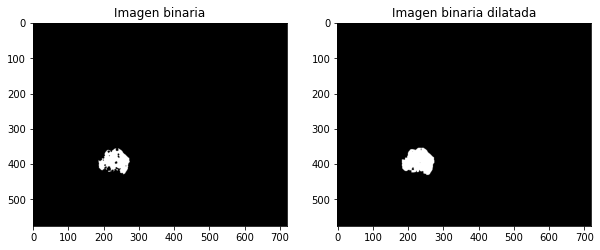

In [ ]:
kernel = np.ones((5, 5), 'uint8')

dilate_img = cv2.dilate(imagen_final, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(imagen_final,cmap='gray'),plt.title('Imagen binaria')
plt.subplot(122),plt.imshow(dilate_img,cmap='gray'), plt.title('Imagen binaria dilatada')
plt.show()

Y vuelvo a dilatar nuevamente

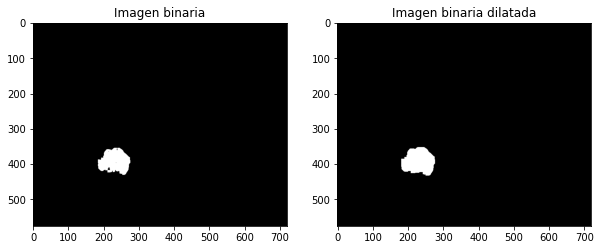

In [ ]:
kernel = np.ones((5, 5), 'uint8')

dilate_img2 = cv2.dilate(dilate_img, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(dilate_img,cmap='gray'),plt.title('Imagen binaria')
plt.subplot(122),plt.imshow(dilate_img2,cmap='gray'), plt.title('Imagen binaria dilatada')
plt.show()

#Inciso B


¿Se puede realizar una segmentación por color? Justificar y probar. Pensar en separar la imagen en las tres capas de color (RGB).

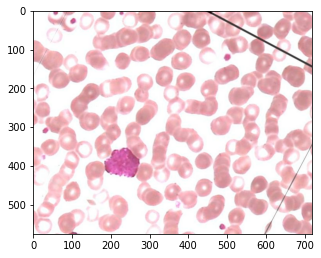

uint8


In [ ]:
imagen2 = cv2.imread('/content/drive/MyDrive/PIB/Segmentacion/img20.jpg',1)

plt.figure(figsize=(5,5))
plt.imshow(imagen2)
plt.show()

print(imagen2.dtype)

Como cv2 lee la imagen en BGR, debemos cambiarla a RGB

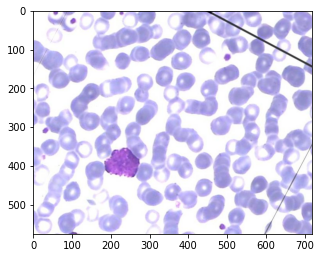

In [ ]:
imagen3 = cv2.cvtColor(imagen2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen3)
plt.show()

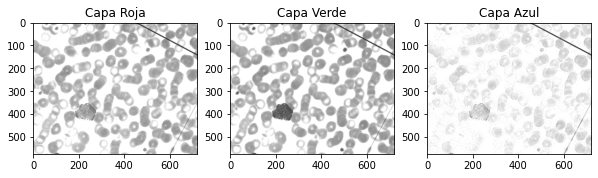

In [ ]:
#Podemos visualizar las distintas capas por separado

plt.figure(figsize=(10,25))
plt.subplot(131),plt.imshow(imagen3[:,:,0], cmap="gray"), plt.title('Capa Roja')
plt.subplot(132),plt.imshow(imagen3[:,:,1], cmap="gray"), plt.title('Capa Verde')
plt.subplot(133),plt.imshow(imagen3[:,:,2], cmap="gray"), plt.title('Capa Azul')
plt.show()

Vemos que se podria segmentar por color, de hecho analizando las distintas capas, veo que la capa verde es la que tiene un mayor contraste y por lo tanto quizas permita obtener una segmentacion mejor

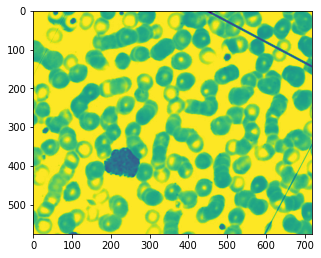

In [ ]:
im_verde=imagen3[:,:,1]
plt.figure(figsize=(5,5))
plt.imshow(im_verde)
plt.show()

Analizo el histograma para aplicar nuevamente el algoritmo de Region Growing pero esta vez en esta capa.

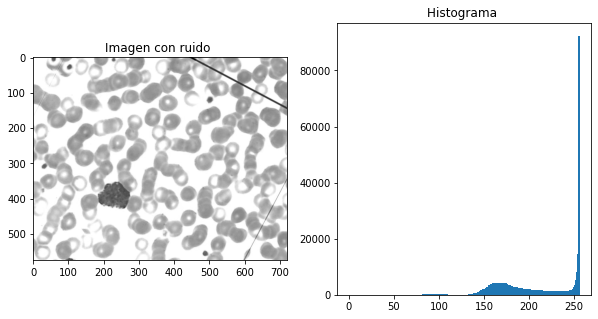

In [ ]:
hist_verde=histograma(im_verde,np.max(im_verde)+1)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(im_verde, cmap="gray", vmin=0, vmax=255), plt.title('Imagen con ruido ')
plt.subplot(122),plt.bar(np.arange(256), hist_verde, width=1.2, align='edge'),plt.title('Histograma ')
plt.show()

Analizando el histograma, observo que lo optimo seria colocar los umbrales entre 50 y 120 aproximadamente

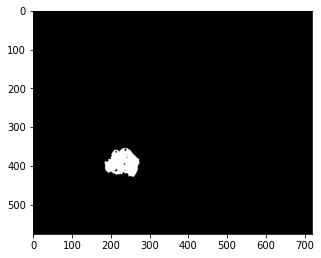

In [ ]:
cel_verde=Region_growing([400,250],50,120,im_verde)
plt.figure(figsize=(5,5))
plt.imshow(cel_verde,cmap = 'gray')
plt.show()

Analogo a lo que realice anteriormente, dilato la imagen para obtener un mejor resultado

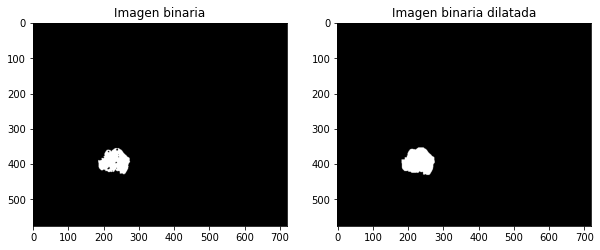

In [ ]:
kernel = np.ones((5, 5), 'uint8')

dilate_img_verde = cv2.dilate(cel_verde, kernel, iterations=1)

plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(cel_verde,cmap='gray'),plt.title('Imagen binaria')
plt.subplot(122),plt.imshow(dilate_img_verde,cmap='gray'), plt.title('Imagen binaria dilatada')
plt.show()

#Inciso C

¿Se puede realizar una segmentación por texturas? ¿Qué métricas de textura servirían para diferenciar esa célula particular del resto de células que se encuentran en la imagen? Justificar y probar. Alguna capa de color podría ayudar más que otra en este caso?

Mediante un análisis de texturas podemos segmentar imágenes. Si calculamos diferentes matrices de co-ocurrencia para distintas porciones de la imagen y luego le calculamos los atributos (energia, contraste, etc) podremos luego agrupar los sectores que presentar dichos valores similares y separarlos de los demás.El tamaño relativo de las ventanas y de los objetos en la imagen determinará que tan útil o no sera esta medida de segmetación siendo recomendable que la ventana sea menor que el objeto y lo suficientemente grande como para capturar la variabilidad del mismo.

Entonces, para realizar esto, aplicare los algoritmos de la matriz de Coocurrencia y ademas las metricas vistas en clase. El análisis de texturas puede hacerse global o por sectores.


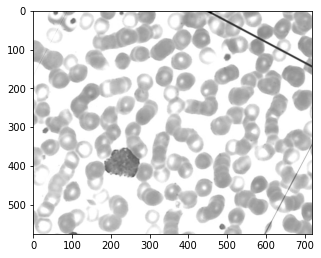

In [ ]:
imagen = cv2.imread('/content/drive/MyDrive/PIB/Segmentacion/img20.jpg',0)

plt.figure(figsize=(5,5))
plt.imshow(imagen,cmap='gray')
plt.show()


Para analizar qué metricas serian adecuadas para segmentar por texturas, tengo en cuenta las definiciones vistas en clase:

Energia mide la uniformidad local. Mientras más alto es el valor, más uniforme es la textura.

\begin{equation}
f_1 = \sum_{i,j}\nolimits g(i, j)^2
\end{equation}

Entropia mide el nivel de organización de una textura. Si es completamente aleatoria, va a tener una muy alta entropía.

\begin{equation}
f_2 =
  \begin{cases}
     \sum_{i,j}\nolimits g(i, j)log_2g(i,j)  & \text{if } g(i, j) \neq 0 \\
     0                                       & \text{if } g(i, j) = 0
  \end{cases}
\end{equation}

 Momento de diferencia inversa mide homogeneidad de la imagen. Valores bajos para imágenes poco homogéneas y altos para imágenes homogeneas.
\begin{equation}
f_4 = \sum_{i,j}\nolimits \frac{1}{1+(i-j)^2}g(i, j)
\end{equation}

Correlacion
Mide la dependencia lineal de los valores de gris en la matriz de co-ocurrencia.
\begin{equation}
f_3 = \sum_{i,j}\nolimits \frac{(i-\mu)(j-\mu)g(i, j)}{\sigma^2}
\end{equation}


$ \mu = \sum_{i,j}\nolimits i \cdot g(i, j) = \sum_{i,j}\nolimits j \cdot g(i, j) $ es el promedio ponderado de los pixeles.

$ \sigma = \sum_{i,j}\nolimits (i - \mu)^2 \cdot g(i, j) = \sum_{i,j}\nolimits (j- \mu)^2 \cdot g(i, j) $ es la varianza ponderada de los píxeles.

Contraste mide la variación local de niveles de gris en la matriz. Si los píxeles vecinos son muy similares, el contraste es bajo.

\begin{equation}
f_5 = \sum_{i,j}\nolimits (i-j)^2g(i, j)
\end{equation}

Cluster Shade se cree que mide la uniformidad percibida de la textura. Un valor alto significa que hay asimetría en la textura.
\begin{equation}
f_6 = \sum_{i,j}\nolimits ((i - \mu)+(j-\mu))^3g(i, j)
\end{equation}

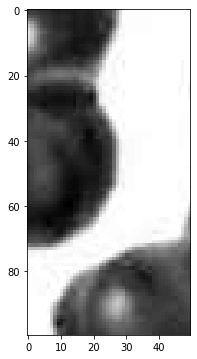

In [ ]:
#Me quedo solo con la parte de interes de la imagen elegida
imagen_fondo= imagen[200:300,450:500]

plt.figure(figsize=(6,6))
plt.imshow(imagen_fondo, cmap="gray")
plt.show()

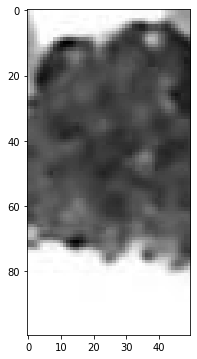

In [ ]:
imagen_celula= imagen[350:450,200:250]

plt.figure(figsize=(6,6))
plt.imshow(imagen_celula, cmap="gray")
plt.show()

In [ ]:
matriz_cel=cooncurrencia_completa(imagen_celula)
metricas(matriz_cel)

,Energia,Entropia,Contraste,Correlacion,IDM,cluster_shade
0,0.010791,-6.693059,67.914264,0.000373,0.237155,2.200607e+06


In [ ]:
matriz_fondo=cooncurrencia_completa(imagen_fondo)
metricas(matriz_fondo)

,Energia,Entropia,Contraste,Correlacion,IDM,cluster_shade
0,0.26711,-14.977282,82.576731,0.000085,1.084468,-8.776819e+06


De estos recortes, vemos que la energia es mayor en el fondo, como asi tambien la IDM.
El cluster shade es significativamente mayor en la imagen de la celula y por lo tanto, considerando que se cree que mide la uniformidad percibida de la textura teniendo este valor alto significa que hay asimetría en la textura.

El momento de diferencia inversa mide homogeneidad de la imagen. Como el valor del recorte de la celula tiene un valor mmás bajo que el de las células del fondo, podemos decir que el fondo de la imagen es homogeneo mientras que la celula es poco homogenea.



In [ ]:
seccion_celula1 = imagen[20:40,30:50]
seccion_celula2 = imagen[20:40,55:75]

promedio_celula=(seccion_celula1+seccion_celula2)/2


seccion_fondo1 = imagen[60:80,10:30]
seccion_fondo2 = imagen[20:40,20:40]

promedio_fondo=(seccion_fondo1+seccion_fondo2)/2

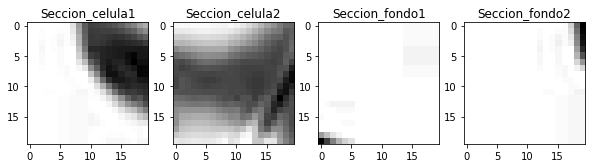

In [ ]:
plt.figure(figsize=(10,25))
plt.subplot(141),plt.imshow(seccion_celula1, cmap="gray"), plt.title('Seccion_celula1')
plt.subplot(142),plt.imshow(seccion_celula2, cmap="gray"), plt.title('Seccion_celula2')
plt.subplot(143),plt.imshow(seccion_fondo1, cmap="gray"), plt.title('Seccion_fondo1')
plt.subplot(144),plt.imshow(seccion_fondo2, cmap="gray"), plt.title('Seccion_fondo2')
plt.show()

In [ ]:
matrizcelula1=cooncurrencia_completa(promedio_celula)
metricas(matrizcelula1)

,Energia,Entropia,Contraste,Correlacion,IDM,cluster_shade
0,0.000319,-4.093664,6.864724,0.003923,0.099392,66170.67589


In [ ]:
matrizfondo1=cooncurrencia_completa(promedio_fondo)
metricas(matrizfondo1)


,Energia,Entropia,Contraste,Correlacion,IDM,cluster_shade
0,0.102744,-9.328711,8.761111,0.00396,0.95902,-29607.082293


De estos recortes, vemos que la energia es mayor en el fondo, como asi tambien la IDM.  El cluster shade es significativamente mayor en la imagen del fondo. Esto no coincide con lo que veiamos antes, por lo tanto se observa la importancia de tomar varios segmentos de la imagen antes de concluir.

El momento de diferencia inversa mide homogeneidad de la imagen. Como el valor del recorte de la celula tiene un valor mmás bajo que el de las células del fondo, podemos decir que el fondo de la imagen es homogeneo mientras que la celula es poco homogenea.  El contraste nuevamente resulta mayor en el caso del fondo, por lo tanto seria tambien una buena metrica para realizar la segmentacion

Con toda esta informacion y la anterior, considerando los valores que tienen una gran diferencia  respecto a la imagen del fondo y de la celula y considerando tambien y tambien comparando que valores son mas altos y mas bajos, observamos que efectivamente se podria segmentar por texturas.  Como ya vimos en el inciso B, la capa de color verde podria ser mejor ya que presenta un mayor contraste que las demas. Esto permitiria segmentar por contraste ya que este nos permitirá diferenciar la variación local de niveles de gris. La energia tambien seria bueno para segmentar ya que es significativamente mayor en la del fondo. Lo mismo aplica para el cluster_shade, que entre el fondo y la celula de interes hay mucha diferencia.

#Inciso D

Calcular el índice de Dice y Jaccard según su segmentación resultante y la segmentación que se encuentra en la imagen img21.jpg

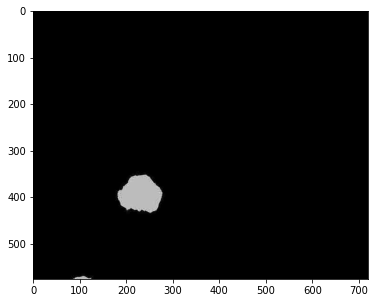

In [ ]:
imagen_objetivo = cv2.imread('/content/drive/MyDrive/PIB/Segmentacion/img21.jpg',0)

plt.figure(figsize=(6,6))
plt.imshow(imagen_objetivo, cmap="gray")
plt.show()

Lo primero que hago es realizar la binarizacion de la imagen para poder compararla con mi imagen obtenida.

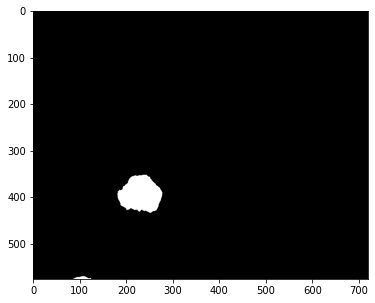

In [ ]:
imagen_obj=Otsu(imagen_objetivo)
plt.figure(figsize=(6,6))
plt.imshow(imagen_obj[0],cmap='gray')
plt.show()


In [ ]:
umbral, imagen_obj = cv2.threshold(imagen_objetivo,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

Para la imagen obtenida por region growing de la capa verde

In [ ]:
indice_j=jaccard(dilate_img_verde,imagen_obj)
indice_dice=dice(dilate_img_verde,imagen_obj)

print('Indice de Jaccard:',indice_j)
print('Indice de Dice:',indice_dice)

Indice de Jaccard: 0.8880799187267185
Indice de Dice: 0.9407228051295848


Para la imagen obtenida con region growing:

In [ ]:
indice_j=jaccard(dilate_img_rg,imagen_obj)
indice_dice=dice(dilate_img_rg,imagen_obj)

print('Indice de Jaccard:',indice_j)
print('Indice de Dice:',indice_dice)

Indice de Jaccard: 0.8852293732145858
Indice de Dice: 0.9391211337908905


Vemos que ambas segmentaciones resultaron ser muy buenas (Los indices son mayores al 80%). Y es solo un poco mejor la segmentacion a partir de la capa verde.